# Load Data

In [1]:
# import packages
import pandas as pd
import numpy as np

# set working directory
import os
os.chdir('/home/jovyan/work/')

In [2]:
from src.data.load_dataset import load_split_store
from sklearn.preprocessing import StandardScaler

# setup scaler
scaler = StandardScaler()

# load_split_store
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler,
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.2, 
                                                                    replace_negatives=False)

# Experiment: Feature Reduction and Supplementation


In this expetiment, it is assumed that taking/adding variables may add to the predictive power of the model. This will be tested by various means (reduce variables, add calculated variables).

Objective:

Feature Reduction: Use analysis of the variables and feature importance XG Boost model function to reduce variables. Compare score with baseline model, including full set.

Feature Supplementation: Add two calculated variables TOV% (Turnover Percentage) and PPG (Points per game) and compare score to baseline. Check feature importance.

Plot Feature Importance
First, the model will be run to plot feature importance using

## Train base model (AUC: 0.722)

In [3]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=8, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.9, max_delta_step=1,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=300, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

-----------
Confusion Matrix with thresthold of 0.5:


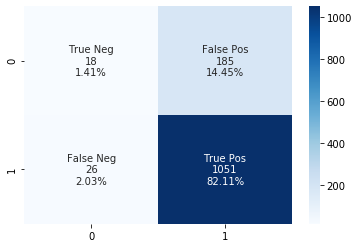

1236 out of 1280 or 97% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9759
Accuracy: 0.8352
F1: 0.9088
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.722


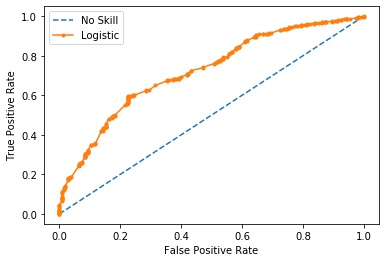

In [7]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = xgb_clf.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

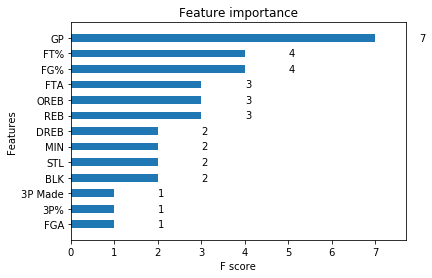

In [5]:
from xgboost import plot_importance

plot_importance(xgb_clf, height=0.5, grid=False)

In [6]:
from joblib import dump

dump(xgb_clf, 'models/final_report_xgb_base.joblib')

['models/final_reprot_xgb_base.joblib']

## Dimensionality Reduction
The following tests are to show the value of removing explanatory variables to reduce dimensionality.

#### Identify feature correlation

In [8]:
corr = X_train.corr()
corr.style.background_gradient()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
GP,1,0.606717,0.5787,0.576313,0.553298,0.273854,0.139275,0.135748,0.0591446,0.523305,0.516111,0.162844,0.391064,0.486241,0.47698,0.411947,0.482283,0.16542,0.537685
MIN,0.606717,1,0.904981,0.89539,0.894868,0.23789,0.36352,0.377512,0.160515,0.767033,0.752218,0.209823,0.544255,0.777169,0.734552,0.643109,0.763124,0.243647,0.794715
PTS,0.5787,0.904981,1,0.989165,0.973079,0.309241,0.336515,0.348402,0.154168,0.864413,0.842988,0.250492,0.547029,0.699745,0.682952,0.57604,0.685251,0.215633,0.817712
FGM,0.576313,0.89539,0.989165,1,0.972552,0.349512,0.287178,0.297659,0.120681,0.810356,0.79876,0.201372,0.571752,0.707407,0.697372,0.553583,0.670228,0.228709,0.800342
FGA,0.553298,0.894868,0.973079,0.972552,1,0.147674,0.373998,0.39979,0.203795,0.785668,0.758812,0.25681,0.469305,0.643393,0.615608,0.622763,0.695907,0.176463,0.818272
FG%,0.273854,0.23789,0.309241,0.349512,0.147674,1,-0.268353,-0.329484,-0.318183,0.291482,0.347141,-0.182047,0.548468,0.429471,0.494933,-0.131855,0.0766209,0.285286,0.129572
3P Made,0.139275,0.36352,0.336515,0.287178,0.373998,-0.268353,1,0.978627,0.587468,0.146781,0.0851213,0.31795,-0.201613,0.0860068,-0.00737732,0.38886,0.310932,-0.0985925,0.238126
3PA,0.135748,0.377512,0.348402,0.297659,0.39979,-0.329484,0.978627,1,0.576955,0.162467,0.097538,0.330716,-0.214004,0.0791003,-0.0165729,0.424208,0.343132,-0.104314,0.262692
3P%,0.0591446,0.160515,0.154168,0.120681,0.203795,-0.318183,0.587468,0.576955,1,0.0140919,-0.0543577,0.348815,-0.291889,-0.0951125,-0.172072,0.301148,0.20164,-0.174096,0.102749
FTM,0.523305,0.767033,0.864413,0.810356,0.785668,0.291482,0.146781,0.162467,0.0140919,1,0.975669,0.268583,0.556047,0.628605,0.635678,0.481569,0.59363,0.208256,0.767456


#### Remove Variables that are Constituents of Other Variables (Base: 0.722, AUC: 0.683, performance decreased by 0.039)

Result: Score drops slightly. Also tried individually for each variable and there is no improvement.

Conclusion: Taking away less constituent variables does not add predictive value.

In [9]:
col_rm = ['3P Made', '3PA', 'FGA', 'FGM','FTA', 'FTM']

X_trnr = X_train.drop(col_rm, axis=1, inplace=False)
X_valr = X_val.drop(col_rm, axis=1, inplace=False)

In [10]:
xgb_clf_rd = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        eval_metric='logloss',
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf_rd.fit(X_trnr, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=8, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.9, max_delta_step=1,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=300, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

-----------
Confusion Matrix with thresthold of 0.5:


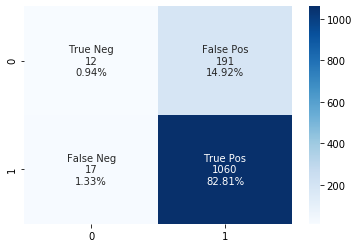

1251 out of 1280 or 98% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9842
Accuracy: 0.8375
F1: 0.9107
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.716


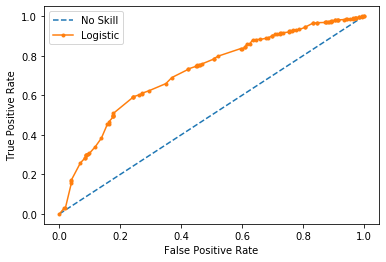

In [11]:
y_val_pred = xgb_clf_rd.predict_proba(X_valr)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

#### Dimensionality Supplement 1: TOV% and PPG (Base: 0.722, AUC: 0.695, performance decreased by 0.027)

Result: Although TOV% is the 'most important' feature along with GP. Adding the two features reduces model performance slightly.

Conclusion: These variables add no value to model performance.

In [12]:
X_trns = X_train.copy()
X_vals = X_val.copy()

X_trns['PPG'] = (X_trns['PTS']/X_trns['GP'])
X_trns['TOV%'] = (100*X_trns['TOV']/(X_trns['FGA']+0.44*X_trns['FTA']+X_trns['TOV']))

X_vals['PPG'] = (X_vals['PTS']/X_vals['GP'])
X_vals['TOV%'] = (100*X_vals['TOV']/(X_vals['FGA']+0.44*X_vals['FTA']+X_vals['TOV']))

In [13]:
xgb_clf_s1 = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        eval_metric='logloss',
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf_s1.fit(X_trns, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=8, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.9, max_delta_step=1,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=300, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

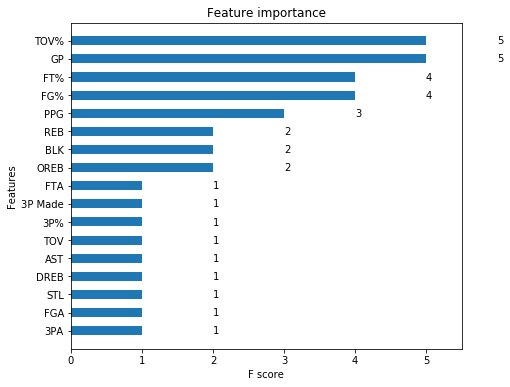

In [14]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (7, 6)
plot_importance(xgb_clf_s1, height=0.5, grid=False)
plt.rcParams["figure.figsize"] = (6.4, 4.8)

-----------
Confusion Matrix with thresthold of 0.5:


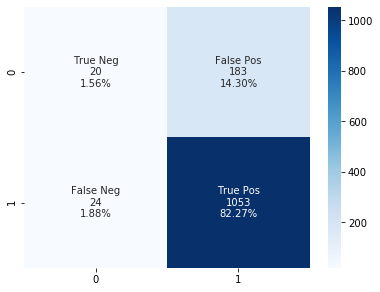

1236 out of 1280 or 97% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9777
Accuracy: 0.8383
F1: 0.9105
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.695


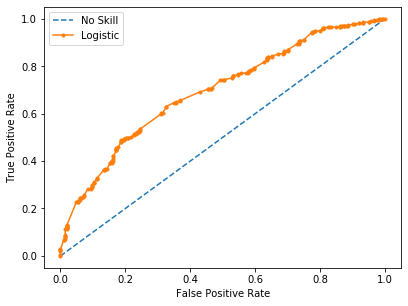

In [15]:
y_val_pred = xgb_clf_s1.predict_proba(X_vals)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

#### Dimensionality Supplement 2: Per Minute Game Stats (Base: 0.722 | AUC: 0.707, performance decreased by 0.015)

Result: Although some of the per minute features are the 'most important' features along with GP, adding it slightly improved the model performnace.

Conclusion: These variables add no value to model performance.

In [16]:
from src.features.build_features import add_features_min_average

X_trns = add_features_min_average(X_train)
X_vals = add_features_min_average(X_val)

In [17]:
xgb_clf_s2 = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        eval_metric='logloss',
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf_s2.fit(X_trns, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=8, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.9, max_delta_step=1,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=300, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

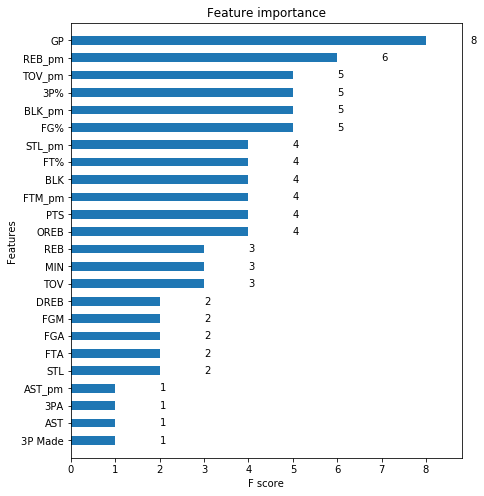

In [18]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (7, 8)
plot_importance(xgb_clf_s2, height=0.5, grid=False)
plt.rcParams["figure.figsize"] = (6.4, 4.8)

-----------
Confusion Matrix with thresthold of 0.5:


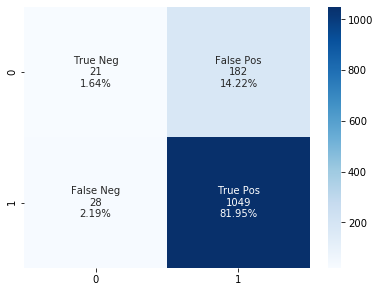

1231 out of 1280 or 96% of players are predicted to be 5+ Yrs
-----------
Recall: 0.974
Accuracy: 0.8359
F1: 0.909
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.653


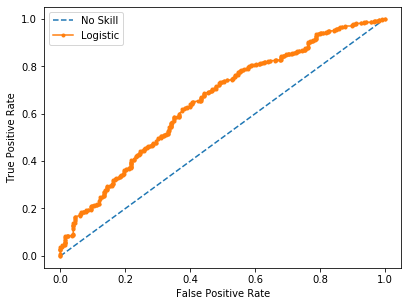

In [19]:
y_val_pred = xgb_clf_s2.predict_proba(X_vals)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

#### Dimensionality Supplement 3: Offensive and Defensive Ratings (Base: 0.722 | AUC: 0.689, performance decreased by 0.033)

Result: Although some of the per minute features are the 'most important' feature along with GP, adding it reduced the model performnace.

Conclusion: These variables add no value to model performance.

In [20]:
from src.features.build_features import add_off_def_features

off_feat = ['PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'AST']
def_feat = ['DREB', 'STL', 'BLK']

X_trns = add_off_def_features(off_feat, def_feat, X_train)
X_vals = add_off_def_features(off_feat, def_feat, X_val)

In [21]:
xgb_clf_s3 = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        use_label_encoder=False,
                        eval_metric='logloss',
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf_s3.fit(X_trns, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=8, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.9, max_delta_step=1,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=300, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, seed=42, silent=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

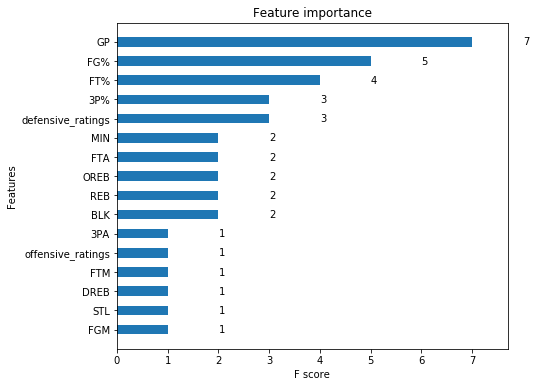

In [22]:
plt.rcParams["figure.figsize"] = (7, 6)
plot_importance(xgb_clf_s3, height=0.5, grid=False)
plt.rcParams["figure.figsize"] = (6.4, 4.8)

-----------
Confusion Matrix with thresthold of 0.5:


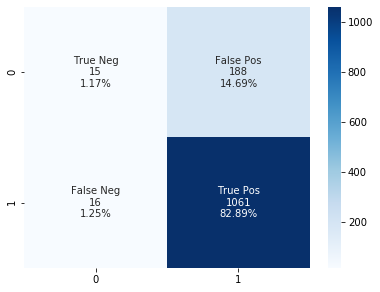

1249 out of 1280 or 98% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9851
Accuracy: 0.8406
F1: 0.9123
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.689


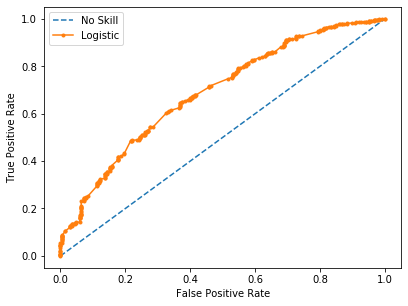

In [23]:
y_val_pred = xgb_clf_s3.predict_proba(X_vals)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.50)

In [24]:
dump(xgb_clf_s3, 'models/final_report_xgb_features.joblib')

['models/final_report_xgb_features.joblib']